In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
class LatentFunction(gpytorch.GridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=50, grid_bounds=[(0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPRegressionModel(gpytorch.GPModel):
    def __init__(self):
        super(GPRegressionModel,self).__init__(GaussianLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)
    
model = GPRegressionModel()
model = model.cuda()

In [4]:
# Optimize the model
def train():
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    optimizer.n_iter = 0
    for i in range(30):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(output, train_y) * 1. / len(train_x)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()

    _ = model.eval()
    
%time train()

Iter 1/30 - Loss: 1.147
Iter 2/30 - Loss: 1.117
Iter 3/30 - Loss: 1.086
Iter 4/30 - Loss: 1.054
Iter 5/30 - Loss: 1.023
Iter 6/30 - Loss: 0.993
Iter 7/30 - Loss: 0.967
Iter 8/30 - Loss: 0.941
Iter 9/30 - Loss: 0.915
Iter 10/30 - Loss: 0.882
Iter 11/30 - Loss: 0.843
Iter 12/30 - Loss: 0.780
Iter 13/30 - Loss: 0.702
Iter 14/30 - Loss: 0.615
Iter 15/30 - Loss: 0.512
Iter 16/30 - Loss: 0.422
Iter 17/30 - Loss: 0.344
Iter 18/30 - Loss: 0.271
Iter 19/30 - Loss: 0.210
Iter 20/30 - Loss: 0.159
Iter 21/30 - Loss: 0.114
Iter 22/30 - Loss: 0.067
Iter 23/30 - Loss: 0.045
Iter 24/30 - Loss: 0.003
Iter 25/30 - Loss: -0.032
Iter 26/30 - Loss: -0.057
Iter 27/30 - Loss: -0.086
Iter 28/30 - Loss: -0.111
Iter 29/30 - Loss: -0.130
Iter 30/30 - Loss: -0.145
CPU times: user 4.82 s, sys: 7.45 s, total: 12.3 s
Wall time: 12.2 s


In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51)).cuda()
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
        ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
        ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

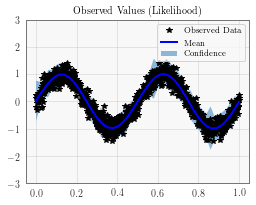

In [6]:
model.condition(train_x, train_y)
f = plot_model_and_predictions(model, plot_train_data=True)